# Application B

In [9]:
import yaml
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from pychromatic import Multiplot
from pychromatic.colors import accent
from tqdm.notebook import trange

Run bcc calculations

In [3]:
with open("input.yaml","r") as fin:
    inp = yaml.load(fin, Loader=yaml.FullLoader)

Modify the potential pathmax_line_width

In [4]:
potential = os.path.join(os.getcwd(), "Ti.eam.fs")
inp["md"]["pair_coeff"] = "* * %s Ti"%potential

Now we have to add bcc specific options

In [2]:
press = np.arange(0, 50000+2500, 2500)

In [6]:
inp["calculations"][0]["lattice"][0] = "BCC"
inp["calculations"][0]["lattice_constant"] = float(3.251)
inp["calculations"][0]["temperature"] = [int(500), int(2250)]
inp["calculations"][0]["repeat"] = [13, 13, 13]
inp["queue"]["jobname"] = "bcc"

In [7]:
calcs = []
for p in press:
    calctemplate = inp["calculations"][0].copy()
    calctemplate["pressure"] = int(p)
    calcs.append(calctemplate)

In [8]:
inp["calculations"] = calcs

Save the input file

In [9]:
with open("input-bcc.yaml", "w", encoding="utf-8") as fout:
    yaml.dump(inp, fout)

Now for hcp structure

In [10]:
with open("input.yaml","r") as fin:
    inp = yaml.load(fin, Loader=yaml.FullLoader)

In [11]:
potential = os.path.join(os.getcwd(), "Ti.eam.fs")
inp["md"]["pair_coeff"] = "* * %s Ti"%potential

Now we have to add hcp specific options

In [12]:
inp["calculations"][0]["lattice"][0] = "HCP"
inp["calculations"][0]["temperature"] = [int(500), int(1500)]
inp["calculations"][0]["iso"] = "False"
inp["queue"]["jobname"] = "hcp"

In [13]:
calcs = []
for p in press:
    calctemplate = inp["calculations"][0].copy()
    calctemplate["pressure"] = int(p)
    calcs.append(calctemplate)

In [14]:
inp["calculations"] = calcs

Save the input file

In [15]:
with open("input-hcp.yaml", "w", encoding="utf-8") as fout:
    yaml.dump(inp, fout)

Now liquid

In [16]:
with open("input.yaml","r") as fin:
    inp = yaml.load(fin, Loader=yaml.FullLoader)

In [17]:
potential = os.path.join(os.getcwd(), "Ti.eam.fs")
inp["md"]["pair_coeff"] = "* * %s Ti"%potential

Now we have to add hcp specific options

In [18]:
inp["calculations"][0]["lattice"][0] = "LQD"
inp["calculations"][0]["temperature"] = [int(1500), int(3000)]
inp["calculations"][0]["state"] = "liquid"
inp["queue"]["jobname"] = "lqd"

In [19]:
calcs = []
for p in press:
    calctemplate = inp["calculations"][0].copy()
    calctemplate["pressure"] = int(p)
    calcs.append(calctemplate)

In [20]:
inp["calculations"] = calcs

Save the input file

In [21]:
with open("input-lqd.yaml", "w", encoding="utf-8") as fout:
    yaml.dump(inp, fout)

Calculations are done, now we can extract the coexistence temperature. 

Get transformation temps:

Go over same pressure ranges

In [6]:
mts = np.load("dcc.npy", allow_pickle=True).flatten()[0]

Now we have the lines, we need to gether free energies and apply the mask

HCP

In [16]:
fharr = []
fhmask = []

for d in trange(len(press)):
    p = press[d]
    t1 = 500
    #we have to find t2
    px = mts['hcp-bcc']['press']
    tx = mts['hcp-bcc']['temp']
    #find where p == px
    arg = np.argsort(np.abs(px-p))[0]
    t2 = tx[arg]
    #fetch free energies
    file = "ts-HCP-500-%d/temperature_sweep.dat"%(int(p))
    t, f = np.loadtxt(file, unpack=True, usecols=(0,1))
    thcp = t
    marr = np.ones(len(f))
    
    for c, fx in enumerate(f):
        if t1<= t[c] <= t2:
            marr[c] = False
    
    fharr.append(f)
    fhmask.append(marr)

  0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
fharr = np.column_stack(fharr)
fhmask = np.column_stack(fhmask)
fharrm = np.ma.array(fharr, mask=fhmask)

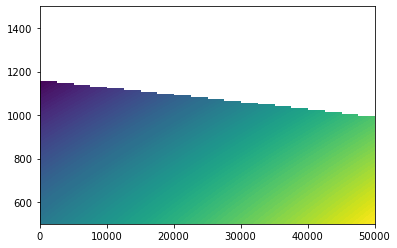

In [18]:
plt.contourf(press, thcp, fharrm, levels=100)

BCC

In [19]:
fbarr = []
fbmask = []

for d in trange(len(press)):
    p = press[d]
    #we have to calculate t1
    px = mts['hcp-bcc']['press']
    tx = mts['hcp-bcc']['temp']
    #find where p == px
    arg = np.argsort(np.abs(px-p))[0]
    t1 = tx[arg]
    
    #we have to find t2
    px = mts['bcc-lqd']['press']
    tx = mts['bcc-lqd']['temp']
    #find where p == px
    arg = np.argsort(np.abs(px-p))[0]
    t2 = tx[arg]
    
    #fetch free energies
    file = "ts-BCC-500-%d/temperature_sweep.dat"%(int(p))
    t, f = np.loadtxt(file, unpack=True, usecols=(0,1))
    tbcc = t
    marr = np.ones(len(f))
    
    for c, fx in enumerate(f):
        if t1<= t[c] <= t2:
            marr[c] = False
    
    fbarr.append(f)
    fbmask.append(marr)

  0%|          | 0/21 [00:00<?, ?it/s]

In [20]:
fbarr = np.column_stack(fbarr)
fbmask = np.column_stack(fbmask)
fbarrm = np.ma.array(fbarr, mask=fbmask)

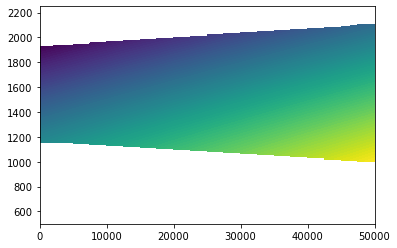

In [21]:
plt.contourf(press, tbcc, fbarrm, levels=100)

LQD

In [22]:
flarr = []
flmask = []

for d in trange(len(press)):
    p = press[d]
    #we have to calculate t1
    px = mts['bcc-lqd']['press']
    tx = mts['bcc-lqd']['temp']
    #find where p == px
    arg = np.argsort(np.abs(px-p))[0]
    t1 = tx[arg]
    
    #we have to find t2
    t2 = 3000
    
    #fetch free energies
    file = "ts-LQD-1500-%d/temperature_sweep.dat"%(int(p))
    t, f = np.loadtxt(file, unpack=True, usecols=(0,1))
    tlqd = t
    marr = np.ones(len(f))
    
    for c, fx in enumerate(f):
        if t1<= t[c] <= t2:
            marr[c] = False
    
    flarr.append(f)
    flmask.append(marr)

  0%|          | 0/21 [00:00<?, ?it/s]

In [23]:
flarr = np.column_stack(flarr)
flmask = np.column_stack(flmask)
flarrm = np.ma.array(flarr, mask=flmask)

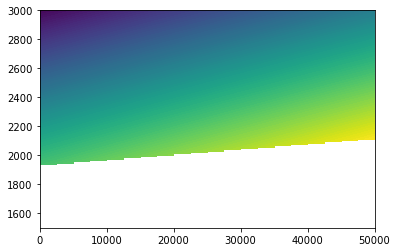

In [24]:
plt.contourf(press, tlqd, flarrm, levels=100)

In [43]:
pmainlist = [0, 10000, 20000, 30000, 40000, 50000]
bh_temp = [1158, 1130, 1101, 1086, 1065, 1030]
bl_temp = [1913, 1948, 2000, 2098, 2114, 2152]

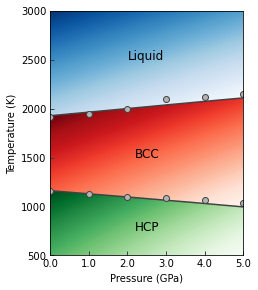

In [45]:
mlt = Multiplot(columns=1, rows=1, width=250, ratio=1.3)

a = mlt[0,0].contourf(press, tbcc, fbarrm, levels=100, cmap="Reds_r")
b = mlt[0,0].contourf(press, thcp, fharrm, levels=100, cmap="Greens_r")
c = mlt[0,0].contourf(press, tlqd, flarrm, levels=100, cmap="Blues_r")

mlt[0,0].plot(mts['hcp-bcc']['press'], mts['hcp-bcc']['temp'], color=accent["dgrey"])
mlt[0,0].plot(mts['bcc-lqd']['press'], mts['bcc-lqd']['temp'], color=accent["dgrey"])

mlt[0,0].set_xlim(0, 50000)
mlt[0,0].set_ylim(500, 3000)

mlt[0,0].plot(pmainlist, bh_temp, 'o', color=accent["pgrey"],
             markeredgecolor=accent["dgrey"])
mlt[0,0].plot(pmainlist, bl_temp, 'o', color=accent["pgrey"],
             markeredgecolor=accent["dgrey"])
mlt[0,0].text(20000, 2500, "Liquid", fontsize=12)
mlt[0,0].text(22000, 1500, "BCC", fontsize=12)
mlt[0,0].text(22000, 750, "HCP", fontsize=12)

mlt[0,0].set_xticks(np.arange(0, 60000, 10000))
mlt[0,0].set_xticklabels(np.arange(0, 60000, 10000)/10000)
mlt[0,0].set_xlabel("Pressure (GPa)")
mlt[0,0].set_ylabel("Temperature (K)")
#mlt[0,0].legend()
plt.savefig("phase_dia_ti.png", dpi=300, bbox_inches="tight")